In [1]:
from google.colab import drive
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Point a

In [ ]:
img_path = '/content/drive/MyDrive/pennfudan/PNGImages'
mask_path = '/content/drive/MyDrive/pennfudan/PedMasks'

img_files = sorted(os.listdir(img_path))
mask_files = sorted(os.listdir(mask_path))
data_pairs = np.array([(os.path.join(img_path, img), os.path.join(mask_path, mask)) for img, mask in zip(img_files, mask_files)])

np.random.shuffle(data_pairs)

data_size = len(data_pairs)
train_size = int(0.8 * data_size)
val_size = int(0.1 * data_size)

train_data = data_pairs[:train_size]
val_data = data_pairs[train_size:train_size + val_size]
test_data = data_pairs[train_size + val_size:]

print(f"# of training samples: {len(train_data)}")
print(f"# of testing samples: {len(test_data)}")
print(f"# of validation samples: {len(val_data)}")

# of training samples: 136
# of testing samples: 17
# of validation samples: 17


Point b

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None, image_size=256):
      self.data = data
      self.transform = transform
      self.image_size = image_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = cv2.imread(self.data[idx][0])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.data[idx][1], 0)
        mask[mask >= 1] = 1
        mask[mask < 1] = 0
        mask *= 255
        merged_input = np.concatenate((image, mask[:, :, None]), axis=2)
        merged_input = transforms.ToTensor()(merged_input)
        if self.transform:
          merged_input = self.transform(merged_input)
        merged_input = transforms.Resize((self.image_size, self.image_size))(merged_input)
        image = merged_input[:3, :, :]
        mask = merged_input[3, :, :].unsqueeze(0)
        return image, mask

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


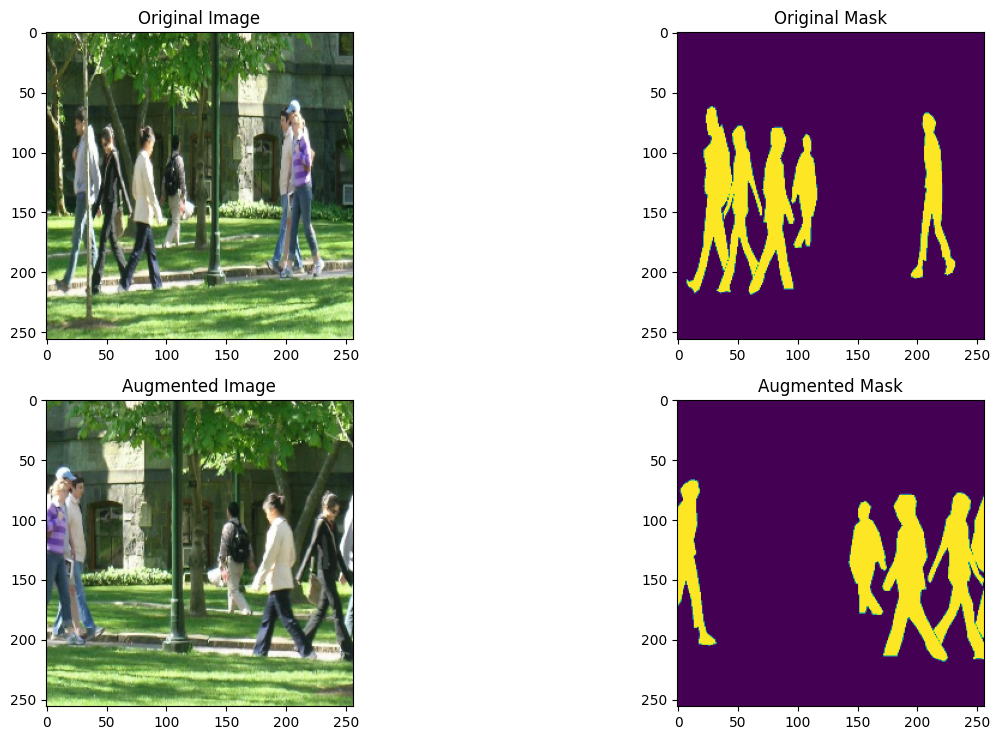

In [ ]:
train_dataset = CustomDataset(train_data)
image, mask = train_dataset[2]

fig, ax = plt.subplots(2, 2, figsize=(15, 7.5))

ax[0,0].imshow(image.permute(1, 2, 0))
ax[0,0].set_title("Original Image")
ax[0,1].imshow(mask.squeeze())
ax[0,1].set_title("Original Mask")

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=(256,256),scale=(0.8, 1.0)),
]
)

augmented_dataset = CustomDataset(
    train_data,
    transform=augmentation)

image, mask = augmented_dataset[2]
ax[1,0].imshow(image.permute(1, 2, 0))
ax[1,0].set_title("Augmented Image")
ax[1,1].imshow(mask.squeeze())
ax[1,1].set_title("Augmented Mask")
plt.tight_layout()
plt.show()

test_dataset = CustomDataset(test_data)
val_dataset = CustomDataset(val_data)

Point c

In [ ]:
class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        self.Conv1 = self.Conv_Double(3, 16)
        self.Down1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv2 = self.Conv_Double(16, 32)
        self.Down2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv3 = self.Conv_Double(32, 32)
        self.Up1 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv4 = self.Conv_Double(64, 16)
        self.Up2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv5 = self.Conv_Double(32, 16)
        self.Conv6 = nn.Conv2d(16, 1, kernel_size=1)

    def Conv_Double(self, input, output):
        return nn.Sequential(
            nn.Conv2d(input, output, kernel_size=3, padding=1),
            nn.BatchNorm2d(output),
            nn.ReLU(inplace=True),
            nn.Conv2d(output, output, kernel_size=3, padding=1),
            nn.BatchNorm2d(output),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out1 = self.Conv1(x)
        out2 = self.Down1(out1)
        out3 = self.Conv2(out2)
        out4 = self.Down2(out3)
        out5 = self.Conv3(out4)
        out6 = self.Up1(out5)
        out7 = torch.cat((out6, out3), dim=1)
        out8 = self.Conv4(out7)
        out9 = self.Up2(out8)
        out10 = torch.cat((out9, out1), dim=1)
        out11 = self.Conv5(out10)
        out12 = self.Conv6(out11)
        out13 = torch.sigmoid(out12)
        return out13

Architecture was implemented from the figure 2.
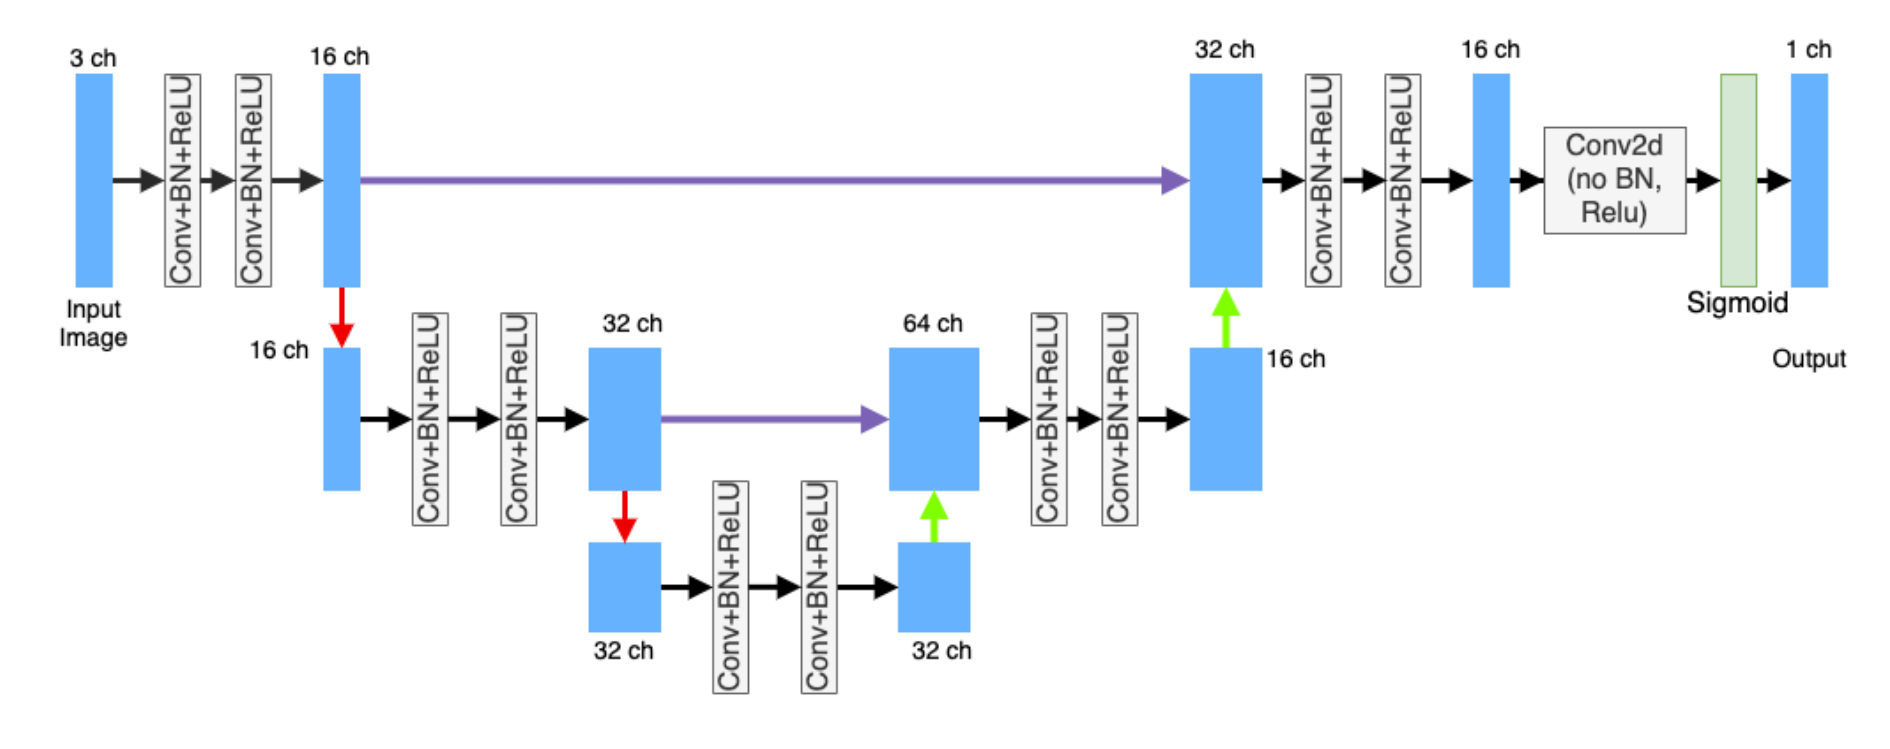

In [ ]:
def dice_coef(actual, expected):
    actual = actual.view(-1)
    expected = expected.view(-1)
    intersection = (actual * expected).sum()
    return (2. * intersection) / (actual.sum() + expected.sum())

class SoftDice(nn.Module):
    def __init__(self):
        super(SoftDice, self).__init__()

    def forward(self, actual, expected, smooth=1):
        actual = actual.view(-1)
        expected = expected.view(-1)
        intersection = (actual * expected).sum()
        return 1 - (2. * intersection + smooth) / (actual.sum() + expected.sum() + smooth)

In [ ]:
def train(model, loader, optimizer, loss_func, device):
    model.train()
    train_loss = 0
    for image, mask in loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        ouput = (model(image))
        loss = loss_func(ouput, mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(loader)

In [ ]:
epochs = 70
lr=1e-3
batch_size=5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_dir = "./models"
model_path = os.path.join(model_dir, "model.pth")
loss_func = SoftDice()
model = UNET().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, verbose=True)

train_loss_list = []
val_loss_list = []
dice_coeffs = []
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)

Epoch number is 70.
Learning rate is 1e-3
Batch size is 5.
Optimizer is Adam.
Loss function is Soft Dice.


In [ ]:
def save_model(filename, model, optimizer, epoch, val_loss):
    folder_name = os.path.dirname(filename)
    if not os.path.isdir(folder_name):
      os.makedirs(folder_name)

    torch.save({
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
        "loss": val_loss},
        filename)

def load_model(filename, model, optimizer):
    last_model = torch.load(filename)
    model.load_state_dict(last_model["model"])
    optimizer.load_state_dict(last_model["optimizer"])
    epoch = last_model["epoch"]
    loss = last_model["loss"]
    return model, optimizer, epoch, loss

In [ ]:
def evaluate(model, loader, loss_func, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for image, mask in loader:
            image = image.to(device)
            mask = mask.to(device)
            ouput = torch.round(model(image))
            loss = loss_func(ouput, mask)
            val_loss += loss.item()
            dice_value = dice_coef(ouput, mask)
    return val_loss / len(loader), dice_value

In [ ]:
if os.path.exists(model_path):
    model, optimizer, curr_epoch, val_loss = load_model(model_path, model, optimizer)
    train_loss_list = train_loss_list[:curr_epoch]
    val_loss_list = val_loss_list[:curr_epoch]
else:
    curr_epoch = 0
    val_loss = np.inf
    train_loss = np.inf
count = 0

while curr_epoch < epochs:
    curr_epoch += 1
    train_loss = train(model, train_loader, optimizer, loss_func, device)
    val_loss, dice_value = evaluate(model, val_loader, loss_func, device)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    dice_coeffs.append(dice_value)
    print("Epoch: {}\n".format(curr_epoch),"Train Loss: {:.4f}\n".format(train_loss),"Val Loss: {:.4f}".format(val_loss))
    count = 0
save_model(model_path, model, optimizer, curr_epoch, val_loss)

Epoch: 1
 Train Loss: 0.6378
 Val Loss: 0.5821
Epoch: 2
 Train Loss: 0.5804
 Val Loss: 0.5188
Epoch: 3
 Train Loss: 0.5600
 Val Loss: 0.5378
Epoch: 4
 Train Loss: 0.5297
 Val Loss: 0.5053
Epoch: 5
 Train Loss: 0.5048
 Val Loss: 0.4253
Epoch: 6
 Train Loss: 0.4921
 Val Loss: 0.3262
Epoch: 7
 Train Loss: 0.4681
 Val Loss: 0.3685
Epoch: 8
 Train Loss: 0.4518
 Val Loss: 0.3891
Epoch: 9
 Train Loss: 0.4268
 Val Loss: 0.4055
Epoch: 10
 Train Loss: 0.4262
 Val Loss: 0.4450
Epoch: 11
 Train Loss: 0.3962
 Val Loss: 0.4668
Epoch: 12
 Train Loss: 0.3827
 Val Loss: 0.2697
Epoch: 13
 Train Loss: 0.3723
 Val Loss: 0.3154
Epoch: 14
 Train Loss: 0.3671
 Val Loss: 0.2653
Epoch: 15
 Train Loss: 0.3379
 Val Loss: 0.2707
Epoch: 16
 Train Loss: 0.3676
 Val Loss: 0.3825
Epoch: 17
 Train Loss: 0.3314
 Val Loss: 0.2984
Epoch: 18
 Train Loss: 0.3084
 Val Loss: 0.2297
Epoch: 19
 Train Loss: 0.3064
 Val Loss: 0.2855
Epoch: 20
 Train Loss: 0.3099
 Val Loss: 0.3256
Epoch: 21
 Train Loss: 0.3048
 Val Loss: 0.2386
E

In [ ]:
if os.path.exists(model_path):
    model, optimizer, curr_epoch, val_loss = load_model(model_path, model, optimizer)
    print("Model loaded")
    train_loss_list = train_loss_list[:curr_epoch]
    val_loss_list = val_loss_list[:curr_epoch]
else:
    curr_epoch = 0
    val_loss = np.inf
    train_loss = np.inf
count = 0
max_epochs = 300
while optimizer.param_groups[0]['lr'] > 1e-6 and curr_epoch < max_epochs:
    curr_epoch += 1
    train_loss = train(model, train_loader, optimizer, loss_func, device)
    val_loss, dice_value = evaluate(model, val_loader, loss_func, device)
    scheduler.step(val_loss)
    train_loss_list.append(train_loss)
    if val_loss < np.min(val_loss_list):
      print("Record low validation loss reached. Saving model.")
      save_model(model_path, model, optimizer, curr_epoch, val_loss)
    val_loss_list.append(val_loss)
    dice_coeffs.append(dice_value)
    count = 0
    print("Epoch: {}\n".format(curr_epoch),"Train Loss: {:.5f}\n".format(train_loss),"Val Loss: {:.5f}".format(val_loss))
    count = 0

Model loaded
Epoch: 71
 Train Loss: 0.19369
 Val Loss: 0.18116
Epoch: 72
 Train Loss: 0.19878
 Val Loss: 0.18716
Epoch: 73
 Train Loss: 0.19393
 Val Loss: 0.19903
Epoch: 74
 Train Loss: 0.19170
 Val Loss: 0.20190
Epoch: 75
 Train Loss: 0.20497
 Val Loss: 0.25934
Epoch: 76
 Train Loss: 0.18572
 Val Loss: 0.19978
Epoch: 77
 Train Loss: 0.19648
 Val Loss: 0.19880
Epoch: 78
 Train Loss: 0.19118
 Val Loss: 0.21199
Record low validation loss reached. Saving model.
Epoch: 79
 Train Loss: 0.17957
 Val Loss: 0.15857
Epoch: 80
 Train Loss: 0.16995
 Val Loss: 0.20633
Epoch: 81
 Train Loss: 0.18513
 Val Loss: 0.17499
Epoch: 82
 Train Loss: 0.17769
 Val Loss: 0.18114
Epoch: 83
 Train Loss: 0.19023
 Val Loss: 0.33677
Epoch: 84
 Train Loss: 0.18935
 Val Loss: 0.22110
Epoch: 85
 Train Loss: 0.19564
 Val Loss: 0.17415
Epoch: 86
 Train Loss: 0.19299
 Val Loss: 0.17368
Epoch: 87
 Train Loss: 0.18714
 Val Loss: 0.16044
Epoch: 88
 Train Loss: 0.19173
 Val Loss: 0.17035
Epoch: 89
 Train Loss: 0.19128
 Val L

Point d


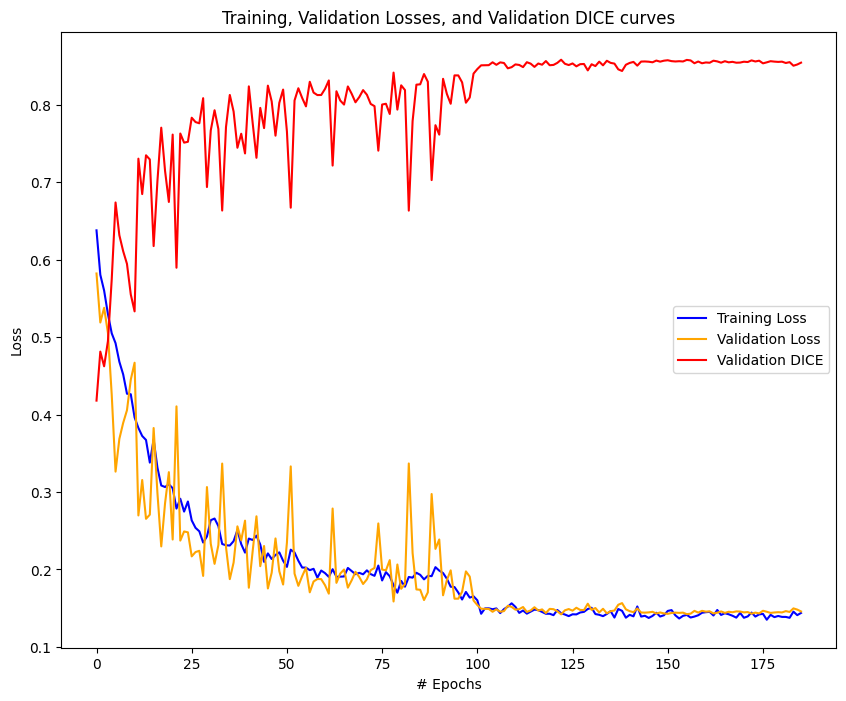

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(train_loss_list, label="Training Loss", color='blue', linestyle='-')
plt.plot(val_loss_list, label="Validation Loss", color='orange', linestyle='-')
plt.plot(1 - np.array(val_loss_list), label="Validation DICE", color='red', linestyle='-')
plt.title("Training, Validation Losses, and Validation DICE curves")
plt.xlabel("# Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

According to the plot above, the model was well fit overall.

Point e

In [ ]:
# Report the average dice score over your test-set.
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
model.eval()
dice_coeffs = []
with torch.no_grad():
    for image, mask in test_loader:
        image = image.to(device)
        mask = mask.to(device)
        output = torch.round(model(image))
        output = output.cpu()
        mask = mask.cpu()
        output = np.squeeze(output, axis=1)
        mask = np.squeeze(mask, axis=1)
        for i in range(output.shape[0]):
            dice_coeffs.append(dice_coef(output[i], mask[i]))
print("Average dice score: {:.2f}".format(np.mean(dice_coeffs)))

Average dice score: 0.78


Point f

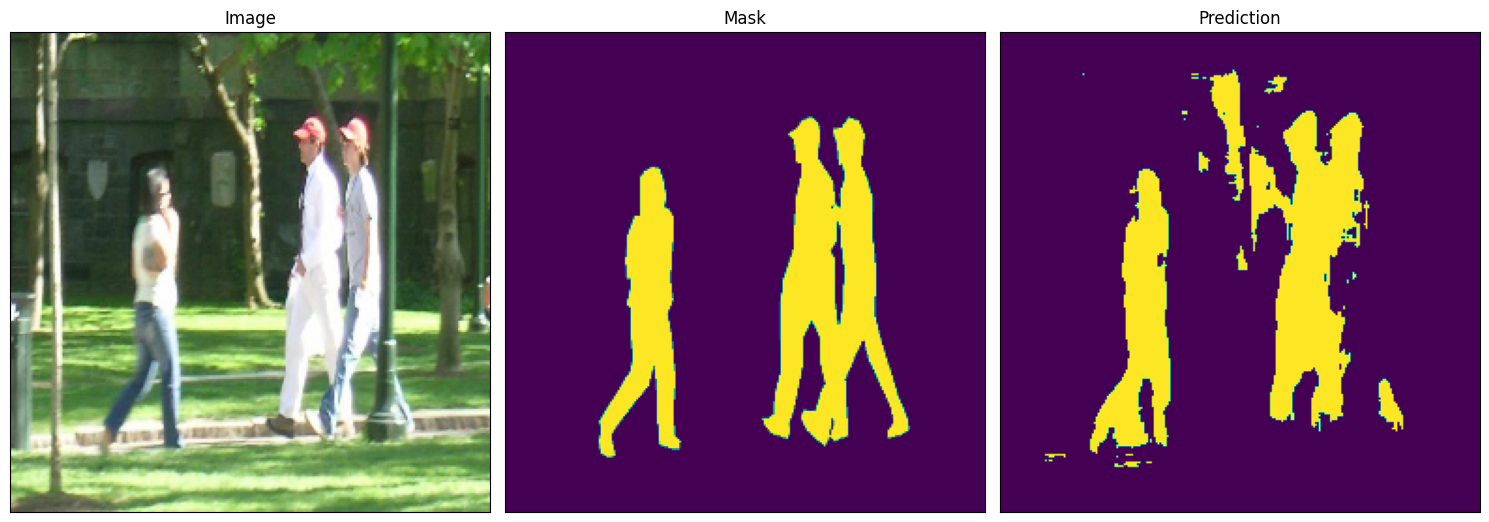

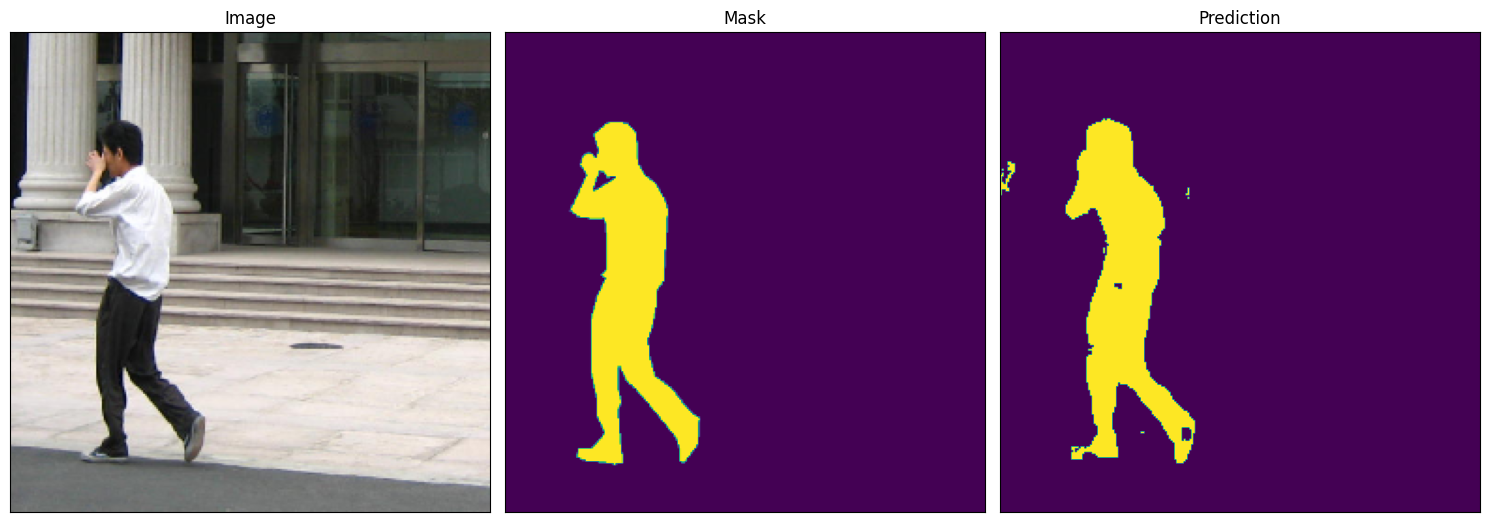

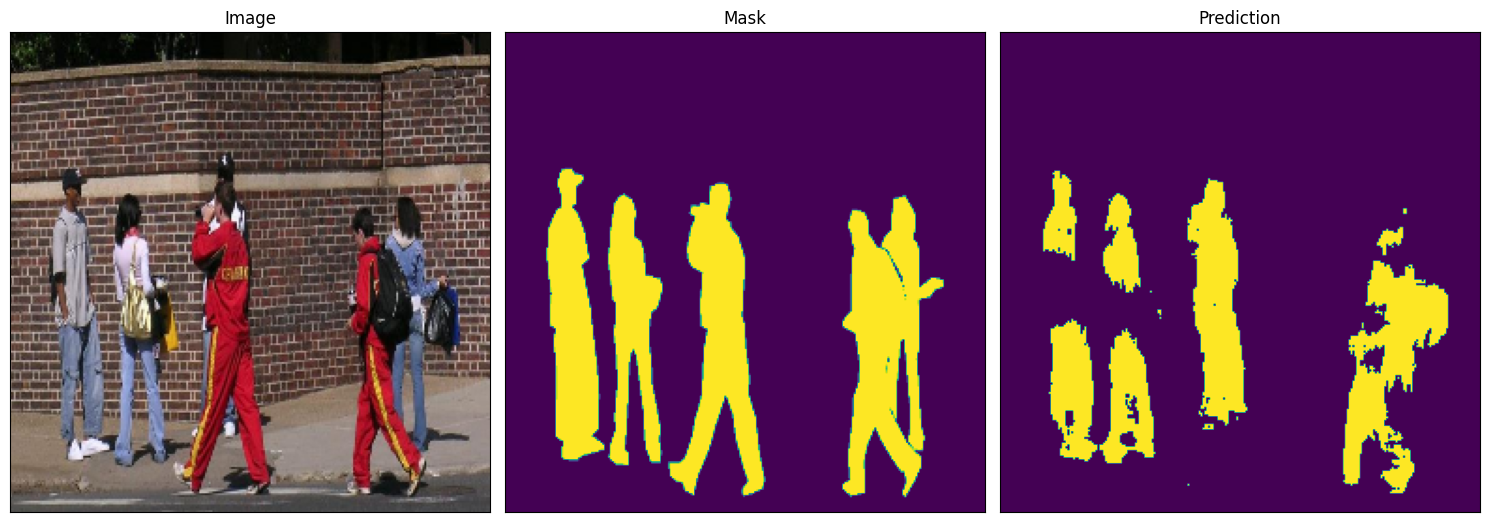

In [ ]:
model, optimizer, curr_epoch, val_loss = load_model(model_path, model, optimizer)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False)
model.eval()
with torch.no_grad():
    image, mask = next(iter(test_loader))
    image = image.to(device)
    mask = mask.to(device)
    output = torch.round(model(image))
    image = image.cpu().numpy()
    output = output.cpu().numpy()
    mask = mask.cpu().numpy()
    image = image.transpose(0, 2, 3, 1)
    output = np.squeeze(output, axis=1)
    mask = np.squeeze(mask, axis=1)
    for i in range(3):
        fig, ax = plt.subplots(1, 3, figsize=(15, 15))
        ax[0].imshow(image[i])
        ax[0].set_title("Image")
        ax[1].imshow(mask[i])
        ax[1].set_title("Mask")
        ax[2].imshow(output[i])
        ax[2].set_title("Prediction")
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])
        plt.tight_layout()
        plt.show()

Point g

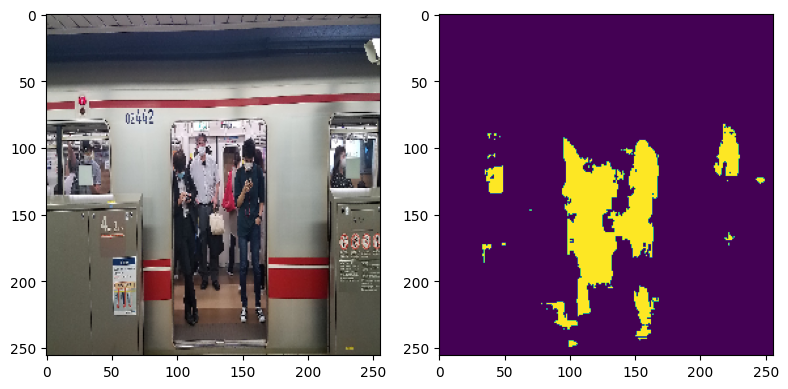

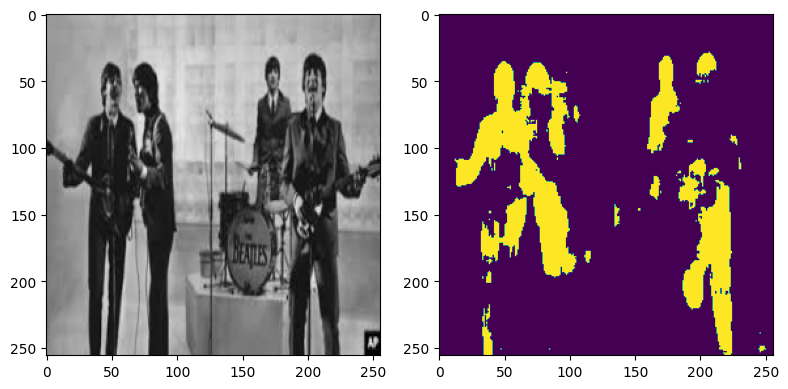

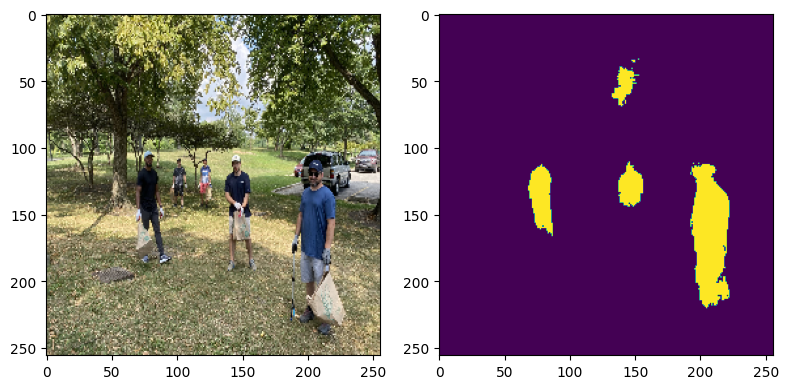

In [ ]:
model, optimizer, curr_epoch, val_loss = load_model(model_path, model, optimizer)
model.eval()
with torch.no_grad():
   for image in os.listdir("./example_images"):
      if not (image.endswith(".jpg") or image.endswith(".jpeg")):
        continue
      image = cv2.imread(os.path.join("./example_images/", image))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (256, 256))
      image = image.transpose(2, 0, 1)
      image = image / 255
      image = torch.from_numpy(image).float()
      image = image.to(device)
      output = model(image[None, ...])
      output = torch.round(output)
      output = output.cpu().numpy()
      output = np.squeeze(output)
      image = image.cpu().numpy()
      image = image.transpose(1, 2, 0)
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
      ax1.imshow(image, aspect="auto")
      ax2.imshow(output, aspect="auto")
      plt.tight_layout()
      plt.show()